In [2]:
import pandas as pd
import string
# import pymysql

from configparser import ConfigParser
import dateutil.parser
import os
from os import remove
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import copy as cp
import re
from langdetect import detect_langs, detect
import pickle
import time

from sklearn.metrics import confusion_matrix
from sklearn import metrics

from DAS_lib import *

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 54)

from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import spacy
#python -m spacy download en_core_web_sm

spanish_stopwords = stopwords.words('spanish')
stemmer = SnowballStemmer('spanish')
lemmatizer = WordNetLemmatizer()
nlp = spacy.load('en_core_web_sm')

spanish_stopwords.append('gracias')
spanish_stopwords.append('martorell')
spanish_stopwords.append('saludos')
spanish_stopwords.append('saludo')
spanish_stopwords.append('hola')
punctuation+='•▪¿¡“”•'

spanish_stopwords.remove('no')
spanish_stopwords.remove('sí')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.decomposition import PCA


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


In [2]:
%%time
# ojo que he puesto preprocesing=False y asi carga todo, no solo AMS
HDF_DIRECTORY='Z:/DATA/'
# HDF_DIRECTORY='D:/LocalDATAANALYTICS/99.DATA/'
ORIGIN_DATA='hdf_files' #'mysql_db'
df_cis,df_apps,df_all_areas, \
df, \
df_rt,df_rt_exc, \
df_changes, \
df_problems, \
df_d,df_dw,df_d_ticket_inc,df_d_ticket_exc, \
df_lost_cars_yearly,df_lost_cars_monthly, \
df_d_p_123,df_dw_p_123,df_d_p_123_ticket_inc,df_d_p_123_ticket_exc, \
df_ams, \
df_mtbf,mtbf_historical,df_other=load_input_data(origin='hdf_files',preprocesing=False,DIRECTORY_FILES=HDF_DIRECTORY)

CPU times: total: 28.4 s
Wall time: 44.4 s


In [3]:
df.head(5)

,Active Flag,CI Environment,CI ID,CI Location,CI Name,CI Subtype,CI Type,Call Code,Cause Code,Close Time @Timezone,Closed Group,Current Assignment,Current Status,Department,Description,External,History Assignment,History End Time,History Start Time,History Status,History Transfer ID,Impact,Layer 1,Layer 2,Layer 3,Location,Marked as Knowledge Candidate,Master/ Child,No.,Open Group,Open Time @Timezone,Prio,Reference ID,Reported Date @Timezone,Resolved Group,Resolved Time @Timezone,Service Class,Solution,Ticket ID,Ticket Type,Title,Update Time @Timezone,Urgency,VW Completion Group,VW Outage Time From,VW Outage Time To,VW Solution ID
7496,NaN,P,CI00498994,NaN,PH APPLICATION INSTANCE (P-49),Application Instance,NaN,Phone,NaN,NaT,NaN,ESD OPS Service Desk SEAT,Resolved,NaN,Descripción del problema/Solicitud: Usuaria no...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,LLAMADA SIN GESTIÓN,NaN,NaN,NaN,NaN,NaN,2561.0,ESD OPS Service Desk SEAT,2023-07-05 23:59:32,NaN,NaN,NaT,ESD OPS Service Desk SEAT,2023-07-06 00:08:16,NaN,Usuaria nos contacta y después de confirmar lo...,RR16550009,Service Request,LLAMADA SIN GESTIÓN POSTERIOR,2023-07-06 00:08:16,NaN,NaN,NaT,NaT,NaN
7495,NaN,P,CI01653263,NaN,NEWAD MIGRATION (P-49),IT-Business Service,NaN,Phone,NaN,NaT,NaN,ESD OPS Service Desk SEAT,Resolved,NaN,Descripción del problema/Solicitud: El usuario...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,RESET PASSWORD,NaN,NaN,NaN,NaN,NaN,2560.0,ESD OPS Service Desk SEAT,2023-07-05 23:41:50,NaN,NaN,NaT,ESD OPS Service Desk SEAT,2023-07-05 23:42:24,NaN,Se le indica su nueva contraseña de acceso y s...,RR16549943,Service Request,5005- new AD - reset / desbloqueo de windows,2023-07-05 23:42:24,NaN,NaN,NaT,NaT,NaN
7494,NaN,P,CI00499188,NaN,PH ACTIVE DIRECTORY (P-49),Authentication,NaN,Phone,NaN,NaT,NaN,KAM OPS Support SEAT,Transferred,NaN,El usuario genérico [Reported for] está deshab...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,CUENTA DESHABILITADA,NaN,NaN,NaN,NaN,NaN,2559.0,ESD OPS Service Desk SEAT,2023-07-05 23:38:40,NaN,NaN,NaT,NaN,NaT,NaN,NaN,RR16549934,Service Request,Usuario genérico deshabilitado,2023-07-05 23:41:08,NaN,NaN,NaT,NaT,NaN
7493,NaN,P,CI00755055,NaN,MICROSOFT TEAMS (P),Application Instance,NaN,Phone,NaN,NaT,NaN,ESD OPS Service Desk SEAT,Resolved,NaN,Instalar MSTEAMS tras cambio de PC > remoto se...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2558.0,ESD OPS Service Desk SEAT,2023-07-05 23:29:27,NaN,NaN,NaT,ESD OPS Service Desk SEAT,2023-07-05 23:33:31,NaN,Instalamos MSTEAMS > pruebas OK\n\n\nCerramos ...,RR16549902,Service Request,Instalar MSTEAMS tras cambio de PC,2023-07-05 23:33:31,NaN,NaN,NaT,NaT,NaN
7492,NaN,P,CI00499188,NaN,PH ACTIVE DIRECTORY (P-49),Authentication,NaN,Phone,NaN,NaT,NaN,KAM OPS Support SEAT,Transferred,NaN,• Descripción del problema/Solicitud: Usuario ...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,CUENTA DESHABILITADA,NaN,NaN,NaN,NaN,NaN,2557.0,ESD OPS Service Desk SEAT,2023-07-05 22:14:01,NaN,NaN,NaT,NaN,NaT,NaN,NaN,RR16549804,Service Request,URGENTE - 5005_AD - Usuario deshabilitado,2023-07-05 22:19:58,NaN,NaN,NaT,NaT,NaN


# LIMPIEZA DE DATOS

Nos quedamos con las columnas que realmente nos insteresan.

In [4]:
dataframe = df[['Ticket Type','CI ID','CI Name','Title','Description','Solution','Open Time @Timezone','Resolved Time @Timezone','Current Status','Current Assignment','Prio','Impact']]
dataframe.sample(5)

,Ticket Type,CI ID,CI Name,Title,Description,Solution,Open Time @Timezone,Resolved Time @Timezone,Current Status,Current Assignment,Prio,Impact
2533,Incident,NaN,AVON AUDI (P-21),No puedo acceder a AVON - No access,• Descripción del problema/Solicitud:\nUsuario...,The CICIP ressource has been unlocked.,2022-04-12 21:35:20,2022-04-13 15:59:58,Closed,BSPP Service Desk AUDI Germany,4.0,3.0
299,Incident,NaN,WINDOWS 10 (P-49),OOCC Fallo autenticacion sharepoint,Usuario reporta en TECHBAR problemas para acce...,Se revisa y se soluciona habilitando cookies d...,2023-06-26 09:42:42,2023-06-26 09:46:59,Resolved,CLIENT SERVICES OPS Support SEAT,7.0,4.0
6653,Service Request,CI00499188,PH ACTIVE DIRECTORY (P-49),AD_Cambio número de teléfono,Descripción del problema/Solicitud: El usuario...,Request closed with Solution:\nSe confirma dur...,2022-02-14 15:29:47,2022-02-14 15:30:55,Closed,ESD OPS Service Desk SEAT,NaN,NaN
456139,Incident,CI1085575,TI-SYNCRO VW AG (P-11),Acceso a TI-SYNCRO,Hola Esta mañana he obtenido la PKI y al inte...,Escalamos a soporte.,2018-05-21 13:27:56,2018-05-21 13:34:35,Closed,OPS ESD Backoffice SEAT,3.0,3.0
6208,Service Request,CI00497764,SAP SEAT SF (P-49),SAP SEAT SF_ consulta,Descripción del problema/Solicitud:\nEl usuari...,Request closed with Solution:\nLe indicamos a ...,2021-10-08 14:29:19,2021-10-08 14:31:51,Closed,ESD OPS Service Desk SEAT,NaN,NaN


In [5]:
print(dataframe.value_counts(dataframe['Current Status']=='Closed'))
len1 = dataframe.shape[0]
print('Longitud total:',len1)

Current Status
True     845782
False     67890
dtype: int64
Longitud total: 913672


28/03 -> Longitud total: 861456

In [6]:
dataframe = dataframe[dataframe['Solution'].notna()]
dataframe = dataframe[dataframe['Title'].notna()]
dataframe = dataframe[dataframe['Description'].notna()]
dataframe = dataframe[dataframe['CI Name'].notna()]
dataframe = dataframe[dataframe['CI ID'].notna()]

indexNames2 = dataframe[dataframe['Solution'] == 0].index
dataframe.drop(indexNames2,inplace=True)

len2 = dataframe.shape[0]
print('Longitud total:',len2)

Longitud total: 672366


In [7]:
print('Elementos eliminados:', len1-len2)

Elementos eliminados: 241306


Creamos un diccionario con la cuenta de las apariciones de los CI en la base de datos.

In [8]:
lista_ci = list(set(dataframe['CI Name']))
dic={}
for v in lista_ci:
    #if type(v) == str:
    dic[v] = sum(dataframe['CI Name']==v)
    
len1 = len(dic)
print(len1)

2801


Histograma de cantidades de cada CI.

Text(0.5, 0, 'Conjunt de CI')

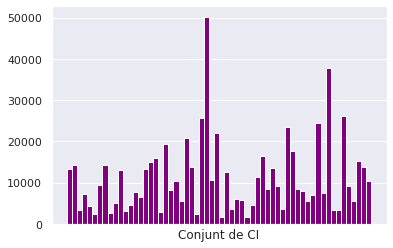

In [10]:
mylist = [key for key, val in dic.items() for _ in range(val)]
plt.hist(mylist, bins=60, color='purple')
plt.xticks([])
plt.xlabel('Conjunt de CI')
#plt.ylabel('Quantitat')
#plt.savefig('fotos_tfg/histograma_CI.png')

Como vemos en el gráfico anterior, hay mucha variedad en el valor de frecuencia de los CI. Realizaremos más visualizacions para hacer mejor el filtrado.

(array([2.675e+03, 4.900e+01, 2.000e+01, 1.500e+01, 1.000e+01, 1.100e+01,
        3.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.00000000e+00, 9.57166667e+02, 1.91333333e+03, 2.86950000e+03,
        3.82566667e+03, 4.78183333e+03, 5.73800000e+03, 6.69416667e+03,
        7.65033333e+03, 8.60650000e+03, 9.56266667e+03, 1.05188333e+04,
        1.14750000e+04, 1.24311667e+04, 1.33873333e+04, 1.43435000e+04,
        1.52996667e+04, 1.62558333e+04, 1.72120000e+04, 1.81681667e+04,
        1.91243333e+04, 2.00805000e+04, 2.10366667e+04, 2.19928333e+04,
        2.29490000e+04, 2.39051667e+04, 2.48613333e+04, 2.58175000e+04,
        2.67736667e+04, 2.77298333e+04, 2.86860000e+04]),
 <BarContainer object of 30 artists>)

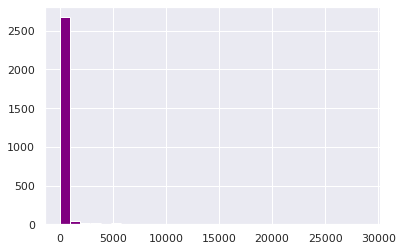

In [11]:
d = pd.DataFrame([[key, dic[key]] for key in dic.keys()], columns=['CI Name', 'Count'])
plt.hist(d['Count'],bins=30,color='purple')

(array([1638.,  235.,  106.,   66.,   47.,   48.,   28.,   39.,   16.,
          23.,   22.,   18.,    8.,   27.,   15.]),
 array([ 1.        ,  7.53333333, 14.06666667, 20.6       , 27.13333333,
        33.66666667, 40.2       , 46.73333333, 53.26666667, 59.8       ,
        66.33333333, 72.86666667, 79.4       , 85.93333333, 92.46666667,
        99.        ]),
 <BarContainer object of 15 artists>)

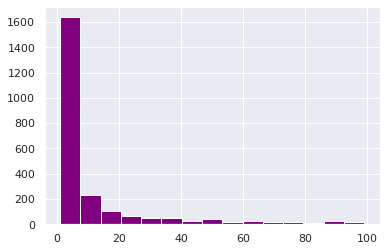

In [12]:
d_1 = d[d['Count']<100]
plt.hist(d_1['Count'],bins=15,color='purple')

(array([781., 299., 181., 124.,   0., 128.,  68.,  57.,  57.,  41.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

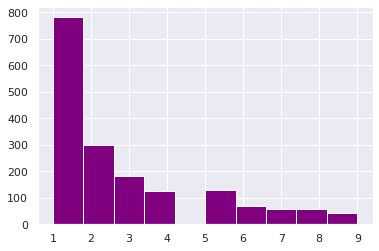

In [13]:
d_1 = d[d['Count']<10]
plt.hist(d_1['Count'],bins=10,color='purple')

Como podemos ver en los gráficos anteriores, hay una gran cantidad de CI que sólo aparecen en la base de datos menos de 6 veces. lo que quiere decir que tenemos muy pocas soluciones de las cuales aprender para este tipo de incidencia. Realizaremos el filtro de no seleccionarlos porque puede provocar ruido en nuestro modelo de aprendizaje.

In [14]:
data1 = dataframe.copy()
data1['count'] = data1.groupby('CI Name')['CI Name'].transform('count')
data1 = data1[data1['count']>5]

In [15]:
#dades = round((dataframe.shape[0]-data1.shape[0])*100/dataframe.shape[0],3)
print(dataframe.shape[0])
print(data1.shape[0])
print('Dades eliminades:',dataframe.shape[0]-data1.shape[0])
data1 = data1.drop('count',axis=1)
#dataframe = data1.copy()

672366
669308
Dades eliminades: 3058


## Eliminar no español y SOLUCIÓN corta

In [16]:
lista_count = list(dataframe['Solution'])
print(len(lista_count))

for i in range(len(lista_count)):
    # ppio de la solucion
    el = lista_count[i]
    
    try:
        idioma = detect(el)
        if idioma == 'es' and len(el) > 29:
            auto1 = el.find('Request closed with Solution')
            if auto1 != -1:
                #print(el)
                lista_count[i] = el[29]
            
            # final de la solución
            el = lista_count[i]
            auto1_3 = el.find('intranet')
            if auto1_2 != -1:
                lista_count[i] = el[:auto1_3]

            # final de la solución
            el = lista_count[i]
            auto1_2 = el.find('Ticket Resuelto/Completado')
            if auto1_2 != -1:
                lista_count[i] = el[:auto1_2]
            
        else:
            lista_count[i] = 0
    except:
        None
    
        
print(len(lista_count))


num1 = sum(1 for i in lista_count if i==0)
num1

672366
672366


153939

In [60]:
data2 = dataframe.copy()
data2['Solution'] = lista_count
data2.sample(10)

p = data2[data2['Solution']==0].index.tolist()
print(p)
data2.drop(p,inplace=True)
data2.shape[0]

[7489, 10403, 10402, 10401, 10397, 10386, 8894, 4932, 8892, 8890, 7444, 7441, 4925, 8881, 10372, 10370, 8879, 7410, 8877, 8876, 7373, 10343, 8867, 8866, 10341, 8865, 8863, 8862, 8861, 8855, 8853, 11938, 10333, 7304, 11999, 11997, 11996, 8908, 11992, 10398, 10395, 8827, 8895, 10380, 10368, 11973, 8881, 8880, 10366, 8879, 8877, 7411, 10361, 8875, 11904, 10271, 10269, 10267, 10266, 7390, 8799, 10260, 4963, 10336, 8867, 4962, 10327, 8864, 7151, 7148, 4957, 8862, 8861, 10307, 8859, 10305, 12062, 12061, 12060, 12058, 12057, 12056, 12055, 12054, 10304, 10299, 8787, 8852, 8851, 12046, 5073, 10292, 7567, 10289, 7271, 7269, 7557, 10462, 7263, 7260, 7253, 10279, 9017, 11911, 12024, 8840, 9012, 9011, 7226, 7505, 7502, 10271, 5066, 7489, 11895, 9008, 7004, 10435, 10432, 10431, 10430, 10429, 10428, 10427, 9000, 11885, 10424, 10423, 7435, 8993, 10418, 10416, 10237, 7040, 7140, 7407, 8991, 7351, 8809, 11873, 10152, 5055, 5054, 5052, 11862, 4853, 10241, 10240, 10239, 10136, 7355, 7354, 7351, 8800, 8794

302022

El tamaño que esta por pantalla no es el que sale en el informe, ya que después de entregar el trabajo sigo haciendo pruebas y trabajando en ello.

In [61]:
p = data2[data2['Solution']==0].index
print(p)
p = data2[data2['Solution']==''].index
print(p)
p = data2[data2['Solution'].isnull()].index
print(p)

Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


       count         name
17625  18069  ACME (P-49)


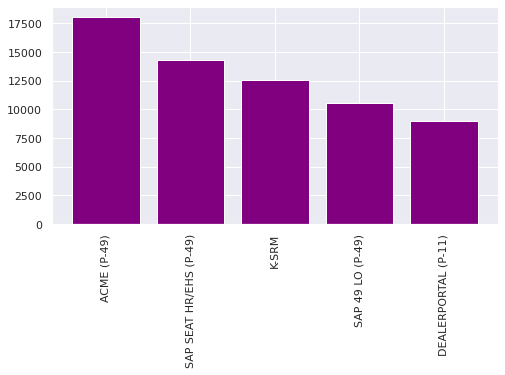

18069
18069


In [62]:
dada = pd.DataFrame()
dada['count'] = data2.groupby('CI Name')['CI Name'].transform('count')
dada['name'] = data2['CI Name']
dada = dada.drop_duplicates()
dada = dada.sort_values('count', ascending=False)
dada2 = dada.head(5).copy()
print(dada2.head(1))

plt.figure(figsize=(8,4))
plt.bar(dada2['name'],dada2['count'],color='purple')
plt.xticks(rotation=90)
plt.show()

datos_ci_acme = data2[data2['CI Name'] == 'ACME (P-49)'].copy()
print(datos_ci_acme.shape[0])
idx = datos_ci_acme[datos_ci_acme['Solution'].apply(lambda x: x[0]==0)].index
datos_ci_acme.drop(idx,inplace=True)
print(datos_ci_acme.shape[0])

# Relacionar service tower con CI


In [63]:
df_cis.shape[0] 

1122

In [64]:
lista_st = list(set(df_cis['Service Tower']))
service_tower = {}
for element in lista_st:
    if type(element) == str:
        service_tower[element] = []
print(service_tower)


{'BI': [], 'IT4IT': [], 'CALIDAD': [], 'HR': [], 'FAB.DIGITAL': [], 'I+D': [], 'DIGITAL': [], 'LOGISTICA': [], 'L/G/FO': [], 'PRODUCCION': [], 'PROD': [], 'FC': [], 'COMPRAS': [], 'COMERCIAL': []}


Guardamos en un diccionario, las llaves: grupos de dervice tower, y valores: los CI que le pertenecen.

In [65]:
l2 = []
c=0
for r in range(df_cis.shape[0]):
    linea = df_cis.iloc[r]
    ci = linea['CI Name']
    st = linea['Service Tower']
    
    if type(ci) == str and type(st) == str:
        if ci in dic.keys():
            if ci not in service_tower[st]:
                c+=1
                service_tower[st].append(ci)
        else:
            if ci not in l2:
                l2.append(ci)

print(c)
service_tower['EXTRA'] = l2
#print(len(l2))


904


In [ ]:
dic_plot = {}
for key in service_tower.keys():
    service_tower[key] = len(service_tower[key])

datos = list(dic_plot.items())

# Separar las claves y los valores en dos listas diferentes
ci, len = zip(*datos)

plt.figure(figsize=(8,4))
plt.bar(ci, len, color='purple',width=0.5)
plt.xticks(rotation=90)

labels=list(dic_plot.keys())
values=list(dic_plot.values())
for i in range(len(labels)):
    plt.text(labels[i], values[i] + 5, str(values[i]), ha='center', va='bottom')

plt.show()
plt.savefig('fotos_tfg/Service_towers.png')

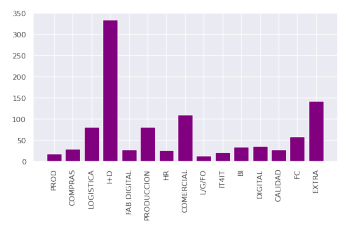

In [73]:
from PIL import Image

# Ruta de la imagen que deseas mostrar
ruta_imagen = 'D:/USUARIS/v4nf6qz/Desktop/v4nf6qz/p/fotos_tfg/Service_towers.png'

# Abrir la imagen con PIL
imagen_pil = Image.open(ruta_imagen)

# Convertir la imagen a una matriz NumPy
imagen_np = np.array(imagen_pil)

# Mostrar la imagen en una figura
plt.figure(figsize=(10,4))
plt.imshow(imagen_np)
plt.axis('off')  # Desactivar los ejes
plt.show()

Se han encontrado 143 CI que no se pueden clasificar en un grupo de Service Towers. Creamos otro campo extra en el dicionario para almacenar estos CI. 

In [27]:
dataframe_st = pd.DataFrame({'CI Name':list(df_cis['CI Name']),'Service Tower':list(df_cis['Service Tower'])})
data3 = pd.merge(data2, dataframe_st, on='CI Name', how='inner')
data3.sample(10)

,Ticket Type,CI ID,CI Name,Title,Description,Solution,Open Time @Timezone,Resolved Time @Timezone,Current Status,Current Assignment,Prio,Impact,Service Tower
197697,Incident,CI2880693,ELIXIR (P-49),Ficheros encolados en el RVS,Se detectan ficheros encolados en el RVS. Esto...,Tras la confirmación por parte del usuario pr...,2017-04-05 16:33:23,2017-04-06 09:31:16,Closed,OPS SYSTEMS WINTEL Advanced Support SEAT,5.0,4.0,FC
110365,Service Request,CI00000093,DEALERPORTAL (P-11),PT676 Dealer Portal desbloqueo de usuario,El usuario se puso en contacto para solicitar ...,\n,2021-01-05 11:18:47,2021-01-05 11:21:11,Closed,GSS Importer Service Desk SEAT Portugal,NaN,NaN,COMERCIAL
28701,Additional Info,CI2880905,CP-TOOL (P-49),IM70952448_ADDITIONAL INFO,el usuario nos llama para consultar el estado ...,Trabajando en el ticket principal. IM70952448,2019-08-14 09:03:01,2019-08-14 09:04:17,Closed,OPS ESD Service Desk SEAT,7.0,4.0,I+D
51779,Incident,CI2880874,TRASYS (P-49),Pantalla Bloqueada,Pedro atienza gamez Descripción incidencia o ...,R5 Se contacta con el usuario y reporta que fu...,2017-02-10 14:32:53,2017-02-10 20:44:24,Closed,OPS FACTORY SYSTEMS Operating SEAT,5.0,4.0,PRODUCCION
274029,Incident,CI1084145,ODIS SERVICE (P-11),03591 - 945890334 Estibaliz Lopez - Problema...,03591 - 945890334 Estibaliz Lopez - Problema...,El error ocurre cuando se actualiza Odis y s...,2017-02-16 13:16:53,2017-02-16 13:20:23,Closed,Importer GSS Service Desk VAESA,5.0,4.0,COMERCIAL
293138,Incident,CI2880850,SGA T12 (P-49),Incidencia SGA: Display M2,Buenas tardes El display M1 M2 M3 y M4 tiene ...,Se limpian directorios del equipo y se libera ...,2018-12-12 10:39:15,2018-12-12 15:38:02,Closed,OPS FACTORY SYSTEMS Onsite Support SEAT,5.0,4.0,LOGISTICA
244959,Service Request,CI2884032,DS (P-49),47304 - [Dealer search] - dealer modification ...,"Hi Support IT,\n\nCould you ask for the update...",Le informamos al usuario que se realizó la act...,2019-05-29 09:28:01,2019-05-29 10:23:57,Closed,Importer GSS Service Desk SEAT Importers,8.0,4.0,DIGITAL
145887,Service Request,CI2880962,QUIRL (P-49),Base de datos QUIRL bloqueada,Necesito que me desbloqueen la cuenta de la ba...,"Se desbloquea usuario de QUIRL, usuario confir...",2019-11-26 09:18:15,2019-11-26 13:20:17,Closed,AMS CAX PDM Support SEAT,8.0,4.0,CALIDAD
86114,Service Request,CI1085326,CONNECT (P-11),Instalación Test Client 6.1.0.23 (No productivo),Necesitaría que se abriera una SR para realiza...,Cliente test CONNECT instalado,2018-10-23 06:35:57,2018-10-23 10:53:55,Closed,AMS CAX CAT Support SEAT,8.0,3.0,I+D
292635,Service Request,CI1083721,KVS (HYPER KVS) (P-11),RV: IM67423621- Acceso a [aplicación],Buenos días Informarles que por parte del KU...,Le informamos que se ha realizado el alta de s...,2019-02-10 07:24:11,2019-02-12 10:02:49,Closed,OPS UMS Service Desk SEAT,8.0,4.0,I+D


In [32]:
p = data3[data3['Solution']==0].index
print(p)
data3.drop(p,inplace=True)
data3.shape[0]

Int64Index([], dtype='int64')


296307

# PROCESAMENTO DEL TEXTO

Eliminamos signos de puntuación

In [35]:
print(punctuation)
print(spanish_stopwords)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~•▪¿¡“”•
['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'est

In [38]:
def clean_text(text):
    if isinstance(text, str):
        tokens = word_tokenize(text, language='spanish')
        clean_tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens if token.translate(str.maketrans('', '', string.punctuation)) != '']
        clean_tokens = [token for token in clean_tokens if token.lower() not in spanish_stopwords]
        return clean_tokens
    else:
        return text

datos_ci_acme['Title'] = datos_ci_acme['Title'].apply(lambda x: clean_text(x) if x != 0 else [])
datos_ci_acme['Description'] = datos_ci_acme['Description'].apply(lambda x: clean_text(x) if x != 0 else [])
datos_ci_acme['Solution'] = datos_ci_acme['Solution'].apply(lambda x: clean_text(x) if x != 0 else [])


In [39]:
data3['Title'] = data3['Title'].apply(lambda x: clean_text(x) if x != 0 else [])
data3['Description'] = data3['Description'].apply(lambda x: clean_text(x) if x != 0 else [])
data3['Solution'] = data3['Solution'].apply(lambda x: clean_text(x) if x != 0 else [])

In [40]:
datos_ci_acme.to_pickle('fotos_tfg/def2/data2_token.pickle')
data3.to_pickle('fotos_tfg/def2/data3_token.pickle')


### SNOWBALL

In [6]:
datos_ci_acme = pd.read_pickle('fotos_tfg/def2/data2_token.pickle')
data3 = pd.read_pickle('fotos_tfg/def2/data3_token.pickle')

In [7]:
p = datos_ci_acme[datos_ci_acme['Solution'].apply(lambda x: all(elem == () for elem in x))].index
print(p)
print(datos_ci_acme.shape[0])
datos_ci_acme.drop(p,inplace=True)
print(datos_ci_acme.shape[0])

Int64Index([ 16281,  14104,   3904,   3282,   3278,  23958,  22617,   3739,
              3492,   2728,
            ...
              2854,  34022,  34034,  34104,  34233,  34270,  34424,   2862,
            253388, 487607],
           dtype='int64', length=212)
18083
17860


In [8]:
extra = []
for count in range(datos_ci_acme.shape[0]):
    a = datos_ci_acme.iloc[count]['Title']
    b = datos_ci_acme.iloc[count]['Description']
    if isinstance(a, list) and isinstance(b, list):
        nueva_a = a.copy()
        nueva_b = b.copy()
        try:
            nueva_a.extend(nueva_b)
        except:
            extra.append(list(nueva_a))
        extra.append(list(nueva_a))
    else:
        extra.append(['-'])
        print('1')

In [43]:
e = []
for palabras in extra:
    l = []
    for p in palabras:
        stemmed_word = stemmer.stem(p)
        l.append(stemmed_word)
    e.append(l)

In [44]:
s = []
for palabras in list(datos_ci_acme['Solution']):
    l = []
    for p in palabras:
        stemmed_word = stemmer.stem(p)
        l.append(stemmed_word)
    s.append(l)

In [105]:
n = 14283 #86351 73691

print(extra[n])
w = [[p.lemma_ for p in nlp(' '.join(ex for ex in extra[n]))]]
print(e[n])
print(w[0])

['Telefono', 'no', 'encoentrado', 'ACME', 'adjunta', 'pantallazo', 'solicitud', 'ACME', 'S170926000015', 'asignación', 'teléfono', 'teléfono', 'utiliza', 'usuario', '937744040', 'no', 'aparece', 'listado', 'ACME', 'ruega', 'introducción', 'manual', 'terminar', 'proceso', 'Silvia', 'Fernández', 'Coordinación', 'Comercial', 'T', '34', '937', '085', '974', 'silviafernandez', 'seates']
['telefon', 'no', 'encoentr', 'acme', 'adjunt', 'pantallaz', 'solicitud', 'acme', 's170926000015', 'asign', 'telefon', 'telefon', 'utiliz', 'usuari', '937744040', 'no', 'aparec', 'list', 'acme', 'rueg', 'introduccion', 'manual', 'termin', 'proces', 'silvi', 'fernandez', 'coordin', 'comercial', 't', '34', '937', '085', '974', 'silviafernandez', 'seat']
['Telefono', 'no', 'encoentrado', 'ACME', 'adjunta', 'pantallazo', 'solicitud', 'ACME', 'S170926000015', 'asignación', 'teléfono', 'teléfono', 'utiliza', 'usuario', '937744040', 'no', 'aparece', 'listado', 'ACME', 'ruega', 'introducción', 'manual', 'terminar', 

In [9]:
datos_prueba1 = datos_ci_acme.copy()
datos_prueba1['Text'] = e
#datos_prueba1['Text'] = extra
datos_prueba1.to_pickle('fotos_tfg/def2/datos_acme_stem_nosol.pickle')
#datos_prueba1.to_pickle('fotos_tfg/def2/ex1.pickle')

In [10]:
datos_prueba1.sample(5)

,Ticket Type,CI ID,CI Name,Title,Description,Solution,Open Time @Timezone,Resolved Time @Timezone,Current Status,Current Assignment,Prio,Impact,Text
809642,Service Request,CI2880607,ACME (P-49),"[Debe, realizarse, peticiónconsulta, través, A...","[usuario, realiza, consulta, no, procede, No, ...","[usuario, ACME, dispone, usted, manuales, deta...",2017-01-13 12:05:20,2017-01-13 12:06:02,Closed,OPS ESD Service Desk SEAT,8.0,3.0,"[Debe, realizarse, peticiónconsulta, través, A..."
210447,Service Request,CI2880607,ACME (P-49),"[permisos, administrador, IM69547283, Debe, re...","[Creo, descargar, addon, no, permiso…, usuario...","[Puede, pedir, permisos, adminsitrador, ACME, ...",2019-05-22 11:13:11,2019-05-22 11:15:02,Closed,OPS ESD Service Desk SEAT,8.0,3.0,"[permisos, administrador, IM69547283, Debe, re..."
236042,Service Request,CI2880607,ACME (P-49),"[acme, consulta]","[dentro, acme, quiere, pedir, software, gratui...","[aportado, informacion, requeria]",2019-04-12 16:37:58,2019-04-12 16:43:02,Closed,OPS ESD Service Desk SEAT,8.0,4.0,"[acme, consulta, dentro, acme, quiere, pedir, ..."
94322,Service Request,CI2880607,ACME (P-49),"[ACME, solicitud, nº, S191111000008]","[ruega, introducción, manual, teléfono, 93708,...","[teléfono, 937086773, actualizado, solicitud, ...",2019-11-11 10:02:16,2019-11-11 10:46:54,Closed,AMS ENTERPRISE SERVICES Support SEAT,8.0,4.0,"[ACME, solicitud, nº, S191111000008, ruega, in..."
451310,Additional Info,CI2880607,ACME (P-49),"[Usuario, disponible]","[escribía, pedirles, si, pueden, desbloquear, ...","[continua, tramite, incidencia, general]",2018-05-28 08:32:31,2018-05-28 08:33:47,Closed,OPS ESD Service Desk SEAT,8.0,3.0,"[Usuario, disponible, escribía, pedirles, si, ..."


# Extraccion características

In [2]:
#datosssss = pd.read_pickle('fotos_tfg/def2/ex1.pickle')
datosssss = pd.read_pickle('D:/USUARIS/v4nf6qz/Desktop/v4nf6qz/p/fotos_tfg/def2/datos_acme_stem_nosol.pickle')

In [3]:
p = datosssss[datosssss['Solution'].apply(lambda x: all(elem == () for elem in x))].index
print(p)
print(datosssss.shape[0])
datosssss.drop(p,inplace=True)
print(datosssss.shape[0])


Int64Index([], dtype='int64')
17860
17860


In [4]:
l = []
for i in range(datosssss.shape[0]):
    if 'ResueltoCompletado' in datosssss.iloc[i]['Solution']:
        indexx = datosssss.iloc[i]['Solution'].index('ResueltoCompletado')
        nueva_lista = datosssss.iloc[i]['Solution'][:indexx]
        l.append(nueva_lista)
    elif 'http' in datosssss.iloc[i]['Solution']:
        indexx = datosssss.iloc[i]['Solution'].index('http')
        nueva_lista = datosssss.iloc[i]['Solution'][:indexx]
        l.append(nueva_lista)
    # tf -> telefono
    else:
        l.append(datosssss.iloc[i]['Solution'])
datosssss['Solution'] = l


In [5]:
lista_de_textos = [' '.join(lista) for lista in list(datosssss['Solution'])]

TF-ID

In [6]:
vectorizer = TfidfVectorizer()
print(len(list(lista_de_textos)))
X_v = vectorizer.fit_transform(lista_de_textos)
matriz_tfidf = X_v.toarray()
len(matriz_tfidf)

17860


17860

COUNTVECTORIZER

In [7]:
vectorizer = CountVectorizer()
caracteristicas_count = vectorizer.fit_transform(lista_de_textos)
matriz_count = caracteristicas_count.toarray()
len(matriz_count)

17860

# CLUSTERING

Procedemos a crear un cluster de soluciones, pq hay muchisimas

TF-ID

In [8]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(matriz_tfidf)

datosssss['cluster'] = kmeans.labels_

clus = {}
for i in range(n_clusters):
    cluster = list(datosssss[datosssss['cluster'] == i]['Solution'].values)
    clus[i] = cluster

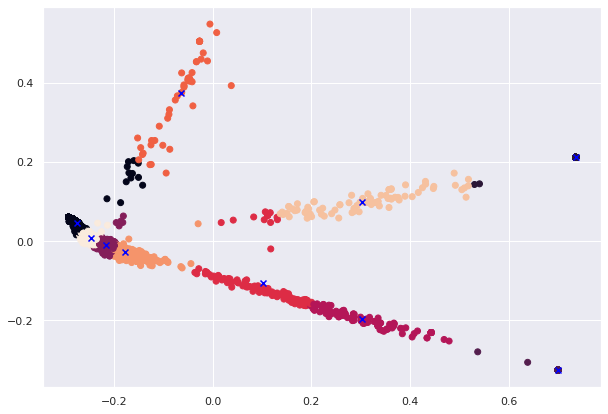

In [55]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(matriz_tfidf)

# Entrenar el modelo
kmeans.fit(X_pca)

# Predecir los clusters para cada punto de datos
labels = kmeans.predict(X_pca)

# Obtener las coordenadas de los centroides
centroids = kmeans.cluster_centers_

# Graficar los clusters y los centroides
plt.figure(figsize=(10,7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='blue')
#plt.xlabel('Component Principal 1')
#plt.ylabel('Component Principal 2')
plt.show()


In [9]:
dic_contador = {}
for c in clus:
    contador = Counter(map(tuple, clus[c]))
    dic_contador[c] = list(sorted(contador.items(), key=lambda item: item[1], reverse=True))

#dic_contador[0]

In [10]:

for i in range(n_clusters):
    iterador = iter(dic_contador[i])
    print(next(iterador))
    print(next(iterador))
    print(next(iterador))
    print(next(iterador))
    print(next(iterador))
    print('---')


(('Solution', 'in', 'Master', 'IM68147884', 'Incidencia', 'relacionada', 'proceso', 'recuperación', 'permisos', 'aplicación', 'funciona', 'correctamente', 'ahora'), 14)
(('Solution', 'in', 'Master', 'IM69962268', 'incidencia', 'sido', 'resuelta', 'problema', 'general', 'ACME'), 12)
(('incidencia', 'sido', 'resuelta', 'problema', 'general', 'ACME'), 9)
(('Solution', 'in', 'Master', 'IM58609298', 'interfaz', 'ACME', 'sido', 'corregida', 'automatizada', 'Cerramos', 'incidencia', 'Solution', 'in', 'Master', 'IM58609298', 'interfaz', 'ACME', 'sido', 'corregida', 'automatizada', 'Cerramos', 'incidencia'), 9)
(('problema', 'debe', 'petición', 'ACME', 'abierto', 'forma', 'incorrecta', 'Cerramos', 'ticket', 'autorización', 'usuaria'), 8)
---
(('usuario', 'ACME', 'dispone', 'usted', 'manuales', 'detallados', 'disponibles', 'intranet', 'SEAT', 'Guías', 'Uso'), 2530)
(('desbloquea', 'cambia', 'clave', 'usuario', 'usuario', 'ACME', 'dispone', 'usted', 'manuales', 'detallados', 'disponibles', 'intra

In [11]:
dic_clus_sol={}
for i in range(n_clusters):
    filas = datosssss[datosssss['cluster'] == i].copy()
    a = filas.shape[0]
    iterador = iter(dic_contador[i])
    primer_element = list(next(iterador)[0])
    if primer_element == []:
        primer_element = list(next(iterador)[0])

    dic_clus_sol[i]=primer_element
    #lista_clus_sol.append((i,primer_element))


In [14]:
dic_clus_sol[6]


['Permisos',
 'Administrador',
 'Local',
 'creados',
 'permisos',
 'efectivos',
 'necesario',
 'reiniciar',
 'equipo',
 '2',
 'ocasiones',
 'hacer',
 'login',
 'usuario',
 'cada',
 'reinicio',
 'caso',
 'permisos',
 'no',
 'aplicado',
 'pruebe',
 'conectar',
 'equipo',
 'directamente',
 'red',
 'Ethernet',
 'repita',
 'proceso',
 'reinicios']

In [16]:
datosssss.to_pickle('D:/USUARIS/v4nf6qz/Desktop/v4nf6qz/p/fotos_tfg/def2/data2_clus_tfidf.pickle')
datosssss.to_pickle('D:/USUARIS/v4nf6qz/Desktop/v4nf6qz/p/fotos_tfg/def2/data2_clus_tfidf_sol.pickle')

COUNTVECTORIZER

In [39]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(matriz_count)

datosssss['cluster'] = kmeans.labels_

clus = {}
for i in range(n_clusters):
    cluster = list(datosssss[datosssss['cluster'] == i]['Solution'].values)
    clus[i] = cluster

In [40]:
dic_contador = {}
for c in clus:
    contador = Counter(map(tuple, clus[c]))
    dic_contador[c] = list(sorted(contador.items(), key=lambda item: item[1], reverse=True))

#dic_contador[0]

In [41]:
"""
for i in range(n_clusters):
    iterador = iter(dic_contador[i])
    print(next(iterador))
    print(next(iterador))
    #print(next(iterador))
    #print(next(iterador))
    #print(next(iterador))
    print('---')
"""

"\nfor i in range(n_clusters):\n    iterador = iter(dic_contador[i])\n    print(next(iterador))\n    print(next(iterador))\n    #print(next(iterador))\n    #print(next(iterador))\n    #print(next(iterador))\n    print('---')\n"

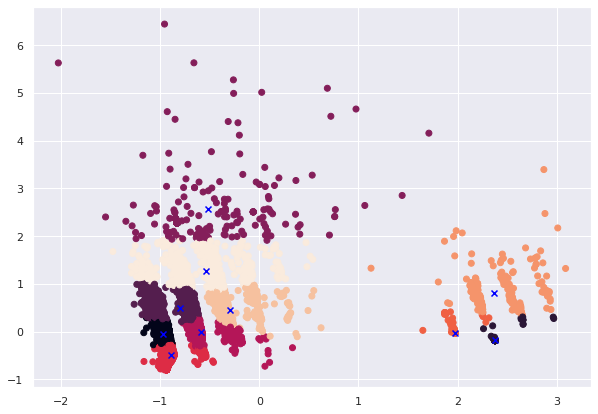

In [42]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(matriz_count)

# Entrenar el modelo
kmeans.fit(X_pca)

# Predecir los clusters para cada punto de datos
labels = kmeans.predict(X_pca)

# Obtener las coordenadas de los centroides
centroids = kmeans.cluster_centers_

# Graficar los clusters y los centroides
plt.figure(figsize=(10,7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='blue')
#plt.xlabel('Component Principal 1')
#plt.ylabel('Component Principal 2')
plt.show()

In [ ]:
l=[]
for i in range(n_clusters):
    filas = datos_ci_acme[datos_ci_acme['cluster'] == i].copy()
    a = filas.shape[0]
    iterador = iter(dic_contador[i])
    primer_element = list(next(iterador)[0])
    if primer_element == []:
        primer_element = list(next(iterador)[0])

    l.append(primer_element)

In [43]:
datosssss.to_pickle('fotos_tfg/def2/data2_clus_count.pickle')

# EXPERIMENTOS

Ir cambiando el valor de i para hacer pruebas necesarias y decidir que extr es mejor

In [17]:
i = 1
if i == 1:
    datos2 = pd.read_pickle('d:/USUARIS/v4nf6qz/Desktop/v4nf6qz/p/fotos_tfg/def/data2_clus_tfidf.pickle')
    #datos2 = pd.read_pickle('d:/USUARIS/v4nf6qz/Desktop/v4nf6qz/p/fotos_tfg/def2/ex2.pickle')
    vectorizer = TfidfVectorizer()
else:
    datos2 = pd.read_pickle('d:/USUARIS/v4nf6qz/Desktop/v4nf6qz/p/fotos_tfg/def/data2_clus_count.pickle')
    vectorizer = CountVectorizer()


In [18]:
datos2.sample(6)

,Ticket Type,CI ID,CI Name,Title,Description,Solution,Open Time @Timezone,Resolved Time @Timezone,Current Status,Current Assignment,Prio,Impact,Text,cluster
348142,Additional Info,CI2880607,ACME (P-49),"[Tlf, 669050655, Usuario, llama, reclamando, t...","[Tlf, 669050655, Usuario, llama, reclamando, t...","[Tlf, 669050655, Usuario, llama, reclamando, t...",2018-11-22 08:35:36,2018-11-22 08:35:59,Closed,OPS ESD Service Desk SEAT,6.0,3.0,"[tlf, 669050655, usuari, llam, reclam, ticket,...",6
435897,Service Request,CI2880607,ACME (P-49),"[Debe, realizarse, peticiónconsulta, través, A...","[observado, sido, desinstalado, programa, Syst...","[usuario, ACME, dispone, usted, manuales, deta...",2018-06-14 15:47:17,2018-06-14 15:48:11,Closed,OPS ESD Service Desk SEAT,8.0,3.0,"[deb, realiz, peticionconsult, traves, acme, i...",3
646868,Additional Info,CI2880607,ACME (P-49),"[Llama, usuaria, reclamando, incidencia]","[Llama, usuaria, reclamando, incidencia]","[Seguimos, tramitando, incidencia, ticket, pri...",2017-08-29 15:20:53,2017-08-29 15:21:30,Closed,OPS ESD Service Desk SEAT,6.0,3.0,"[llam, usuari, reclam, incident, llam, usuari,...",7
96057,Service Request,CI2880607,ACME (P-49),"[ACCESO, INTERNET]","[usuaria, solicita, acceso, internet]","[informamos, debe, solicta, acceso, través, ACME]",2019-11-08 13:19:14,2019-11-08 13:22:59,Closed,OPS ESD Service Desk SEAT,8.0,4.0,"[acces, internet, usuari, solicit, acces, inte...",2
302156,Service Request,CI2880607,ACME (P-49),"[Alta, perfil, técnico, ACME, FIOV0XR]","[Necesitamos, usuario, dominio, reported, for,...","[Permisos, concedidos, asignado, grupo, indicado]",2019-02-01 11:24:26,2019-02-01 13:13:19,Closed,AMS IT CROSS SERVICES OPEN Support SEAT,8.0,3.0,"[alta, perfil, tecnic, acme, fiov0xr, necesit,...",4
199538,Service Request,CI2880607,ACME (P-49),"[instalacion, microsoft, project]","[Buenos, días, Solicito, instalación, programa...","[Buenos, días, debe, realizar, solicitud, vía,...",2019-06-06 08:53:28,2019-06-06 08:55:42,Closed,OPS ESD Service Desk SEAT,8.0,3.0,"[instal, microsoft, project, buen, dias, solic...",2


## COMPARACIÓN ALGORISMOS

PRUEBAS CON OTROS ALGORISMOS

In [19]:
"""
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

#data3_2 = data3[data3['CI Name'] == 'ACME (P-49)'].copy()

descriptions = []
for lista in list(datos_ci_acme['Description']):
    sentence = ' '.join(lista)
    descriptions.append(sentence)
    
solutions = []
for lista in list(datos_ci_acme['Solution']):
    sentence = ' '.join(lista)
    solutions.append(sentence)

# Cargar el modelo pre-entrenado GPT-2
model_name = 'gpt2'
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Tokenizar los datos de entrenamiento
input_ids = []
attention_masks = []
tokenizer.pad_token = tokenizer.eos_token

for description, solution in zip(descriptions, solutions):
    encoded_input = tokenizer.encode_plus(
        description,
        text_pair=solution,
        add_special_tokens=True,
        max_length=512,
        truncation = True,
        truncation_strategy='only_first',
        pad_to_max_length=True,
        return_tensors='pt',
)

    input_ids.append(encoded_input['input_ids'])
    attention_masks.append(encoded_input['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Entrenar el modelo
model.train()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

train_dataset = torch.utils.data.TensorDataset(input_ids, attention_masks)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

for epoch in range(5):
    total_loss = 0
    for batch in train_loader:
        batch_input_ids, batch_attention_masks = batch

        optimizer.zero_grad()

        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_input_ids)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch + 1}: Loss = {total_loss:.2f}')

"""


"\nfrom transformers import GPT2Tokenizer, GPT2LMHeadModel\nimport torch\n\n#data3_2 = data3[data3['CI Name'] == 'ACME (P-49)'].copy()\n\ndescriptions = []\nfor lista in list(datos_ci_acme['Description']):\n    sentence = ' '.join(lista)\n    descriptions.append(sentence)\n    \nsolutions = []\nfor lista in list(datos_ci_acme['Solution']):\n    sentence = ' '.join(lista)\n    solutions.append(sentence)\n\n# Cargar el modelo pre-entrenado GPT-2\nmodel_name = 'gpt2'\nmodel = GPT2LMHeadModel.from_pretrained(model_name)\ntokenizer = GPT2Tokenizer.from_pretrained(model_name)\n\n# Tokenizar los datos de entrenamiento\ninput_ids = []\nattention_masks = []\ntokenizer.pad_token = tokenizer.eos_token\n\nfor description, solution in zip(descriptions, solutions):\n    encoded_input = tokenizer.encode_plus(\n        description,\n        text_pair=solution,\n        add_special_tokens=True,\n        max_length=512,\n        truncation = True,\n        truncation_strategy='only_first',\n        pad_

In [20]:
listaa = []
for lista in list(datos2['Text']):
    sentence = ' '.join(lista)
    listaa.append(sentence)

X_train, X_test, y_train, y_test = train_test_split(listaa, list(datos2['cluster']), test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

train_text = vectorizer.fit_transform(X_train)
test_text = vectorizer.transform(X_test)

Realizar los diferendes GridSearchCV de cada algorismo

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0)
distributions = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'penalty':['none', 'elasticnet', 'l1', 'l2'],
              'C':[0.001, 0.01, 0.1, 1, 10, 100]}
clf = GridSearchCV(model, distributions, refit=True,scoring = 'accuracy',cv = 5,verbose=0)

"""
model = SGDClassifier(random_state=0)
distributions = {'alpha':[0.001, 0.01, 0.1, 1],
                 'eta0':[0.1,0.01],
                 'learning_rate':['adaptive','optimal','constant','invascaling'],
                 'penalty':['l2','l1'],
                 'tol':[1e-2,1e-3,1e-5,0.07,0.5],
                 'max_iter':[-1,100,10000],
                 'epsilon':[1e-2,1e-3,1e-5],
                 'n_iter_no_change':[2,10,13,15,20],
                 'loss':['squared_hinge','hinge','perceptron','squared_error']
}
clf = GridSearchCV(model, distributions, refit=True)

model = MultinomialNB(random_state=0)
distributions = {'alpha':[0.001, 0.01, 0.1, 1],
}
clf = GridSearchCV(model, distributions, refit=True)

model = RandomForestClassifier(random_state=0)
distributions = { 
    'n_estimators': [10,40,50,100,200,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10,None],
    'criterion' :['gini', 'entropy']
}
clf = GridSearchCV(model, distributions, refit=True)
"""

search = clf.fit(train_text, y_train)
print("BEST PARAMS: {}".format(search.best_params_))
print("BEST SCORE: {}".format(search.best_score_))


BEST PARAMS: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
BEST SCORE: 0.4874881618666884


PRUEBA ANTERIOR HECHA CON COUNTVECTORIZER, ES PERO QUE TDIDF

In [21]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

import time
from sklearn.metrics import confusion_matrix, precision_score,recall_score,f1_score,accuracy_score,ConfusionMatrixDisplay,mean_squared_error,roc_curve


nombres = [
    'Multinomial NB','Logistic Regression','Random Forest',"Linear SVC",'MLP Classifier','SVC',"SGD Classifier"]

modelos = [
    MultinomialNB(alpha=0.1), 
    LogisticRegression(C=2,random_state=0),
    RandomForestClassifier(n_estimators=40,random_state=0),
    LinearSVC(C=0.5,multi_class='crammer_singer',loss='hinge',random_state=0,tol=1.5), 
    MLPClassifier(hidden_layer_sizes=(10,10), shuffle=False, random_state=0,activation='tanh', alpha=0.001,  learning_rate='adaptive', learning_rate_init=0.1, n_iter_no_change=10, solver='sgd', tol=1.3), #11 y sin momentum
    SVC(kernel='linear', C=2, gamma='scale'),
    SGDClassifier(loss='squared_hinge',alpha=0.001,learning_rate='adaptive',shuffle=False,random_state=0,eta0=0.1)
]

pred = []
models = []
time_start = time.time()
for model,nom in zip(modelos,nombres):

    m=model.fit(train_text, y_train)

    predicciones = model.predict(test_text)
    pred.append(predicciones)
    accuracy = accuracy_score(y_test, predicciones)
    recall = recall_score(y_test,predicciones,average='weighted')
    precision = precision_score(y_test,predicciones,average='weighted')
    #f1 = f1_score(y_test,predicciones,average='weighted')
    
    matriz = confusion_matrix(y_test,predicciones)
    
    time_final = time.time()
    models.append((nom,accuracy*100,matriz,recall*100,precision*100,time_final-time_start,predicciones))

    
fin_models = pd.DataFrame(models, columns = ['Name', 'Accuracy','ConfusionMatrix','Recall','Precision','TIME','Predicciones'])



In [22]:
pd.set_option('display.max_colwidth', None)
fin_models = fin_models.sort_values(['Accuracy'],ascending=False)
fin_models

,Name,Accuracy,ConfusionMatrix,Recall,Precision,TIME,Predicciones
2,Random Forest,69.464652,"[[1, 1, 0, 0, 0, 0, 76, 0, 0, 0], [0, 634, 1, 70, 0, 0, 57, 0, 0, 1], [0, 24, 47, 25, 1, 0, 256, 0, 1, 0], [0, 255, 4, 234, 1, 1, 32, 0, 0, 0], [0, 6, 6, 7, 11, 0, 174, 0, 0, 0], [0, 0, 0, 0, 7, 8, 165, 0, 0, 2], [2, 15, 38, 15, 9, 3, 2748, 15, 0, 13], [0, 0, 0, 0, 0, 0, 169, 23, 0, 1], [0, 0, 0, 0, 0, 0, 34, 0, 0, 0], [0, 0, 0, 2, 0, 1, 147, 0, 0, 18]]",69.464652,65.180663,9.932529,"[6, 6, 6, 6, 6, 6, 1, 6, 2, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 6, 6, 1, 6, 9, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 2, 1, 6, 9, 6, 6, 6, 6, 6, 6, 1, 6, 6, 3, 6, 1, 6, 2, 6, 6, 6, 1, 6, 6, 6, 3, 1, 6, 6, 1, 6, 3, 6, 6, 3, 6, 6, 6, 6, 6, 6, 3, 1, 3, 6, 6, 6, 1, 6, 1, ...]"
5,SVC,68.961015,"[[1, 0, 2, 0, 0, 0, 75, 0, 0, 0], [1, 666, 7, 37, 1, 0, 51, 0, 0, 0], [1, 28, 40, 20, 12, 1, 251, 0, 0, 1], [0, 285, 13, 192, 2, 0, 35, 0, 0, 0], [0, 9, 9, 4, 32, 2, 148, 0, 0, 0], [0, 1, 1, 1, 19, 8, 145, 0, 0, 7], [3, 28, 46, 15, 25, 7, 2684, 28, 0, 22], [1, 1, 1, 0, 1, 1, 146, 42, 0, 0], [0, 0, 0, 0, 0, 1, 33, 0, 0, 0], [0, 0, 0, 1, 0, 0, 135, 0, 0, 32]]",68.961015,63.828728,85.443603,"[3, 6, 6, 6, 6, 6, 1, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 1, 3, 1, 6, 6, 1, 6, 9, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 1, 6, 6, 6, 1, 4, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 3, 6, 1, 6, 2, 6, 6, 6, 1, 6, 6, 6, 3, 1, 2, 6, 1, 6, 3, 6, 6, 3, 6, 2, 6, 6, 6, 6, 3, 1, 1, 6, 6, 6, 1, 6, 1, ...]"
1,Logistic Regression,68.755829,"[[0, 0, 2, 0, 0, 0, 76, 0, 0, 0], [0, 642, 3, 39, 1, 0, 78, 0, 0, 0], [1, 27, 32, 20, 9, 0, 264, 0, 0, 1], [0, 268, 10, 186, 0, 0, 63, 0, 0, 0], [0, 7, 7, 5, 25, 0, 160, 0, 0, 0], [0, 0, 1, 0, 15, 6, 159, 0, 0, 1], [5, 24, 31, 11, 19, 4, 2731, 21, 0, 12], [0, 2, 0, 0, 0, 1, 158, 32, 0, 0], [0, 0, 0, 0, 0, 1, 33, 0, 0, 0], [0, 0, 0, 0, 0, 0, 136, 0, 0, 32]]",68.755829,64.049827,4.907911,"[3, 6, 6, 6, 6, 6, 1, 6, 3, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 3, 1, 6, 6, 1, 6, 9, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 1, 6, 6, 7, 6, 6, 6, 6, 6, 1, 6, 6, 3, 6, 1, 6, 2, 6, 6, 6, 1, 6, 6, 6, 3, 1, 2, 6, 1, 6, 6, 6, 6, 3, 6, 2, 6, 6, 6, 6, 3, 1, 1, 6, 6, 6, 1, 6, 1, ...]"
3,Linear SVC,68.476031,"[[1, 0, 0, 0, 0, 0, 77, 0, 0, 0], [1, 651, 3, 27, 1, 0, 78, 2, 0, 0], [1, 32, 13, 21, 5, 0, 282, 0, 0, 0], [0, 294, 14, 169, 0, 0, 50, 0, 0, 0], [0, 11, 5, 6, 16, 2, 164, 0, 0, 0], [0, 0, 0, 2, 10, 4, 162, 1, 0, 3], [2, 27, 4, 15, 15, 2, 2774, 7, 0, 12], [0, 2, 0, 0, 0, 0, 168, 23, 0, 0], [0, 0, 0, 0, 0, 0, 34, 0, 0, 0], [0, 1, 0, 0, 0, 0, 147, 0, 0, 20]]",68.476031,63.380695,9.990364,"[2, 6, 6, 6, 6, 6, 1, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 3, 1, 6, 6, 1, 6, 9, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 1, 6, 1, 6, 3, 6, 6, 6, 1, 6, 1, 6, 3, 1, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 1, 1, 6, 6, 6, 1, 6, 1, ...]"
6,SGD Classifier,67.636635,"[[0, 0, 0, 0, 0, 0, 78, 0, 0, 0], [0, 635, 0, 22, 2, 0, 104, 0, 0, 0], [0, 33, 7, 14, 8, 0, 292, 0, 0, 0], [0, 290, 4, 143, 3, 0, 87, 0, 0, 0], [0, 9, 1, 4, 17, 0, 173, 0, 0, 0], [0, 0, 0, 0, 14, 0, 168, 0, 0, 0], [0, 21, 3, 12, 17, 0, 2797, 2, 0, 6], [0, 1, 0, 0, 0, 0, 178, 14, 0, 0], [0, 0, 0, 0, 0, 0, 34, 0, 0, 0], [0, 0, 0, 0, 0, 0, 155, 0, 0, 13]]",67.636635,62.455746,85.912686,"[6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 1, 6, 6, 1, 6, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 3, 6, 1, 6, 3, 6, 6, 6, 1, 6, 6, 6, 6, 1, 6, 6, 1, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 3, 1, 1, 6, 6, 6, 1, 6, 1, ...]"
4,MLP Classifier,66.573400,"[[4, 1, 3, 0, 1, 0, 67, 1, 0, 1], [2, 650, 5, 60, 0, 0, 43, 1, 0, 2], [2, 27, 66, 28, 10, 0, 219, 1, 0, 1], [0, 272, 9, 219, 2, 1, 24, 0, 0, 0], [0, 6, 18, 8, 36, 0, 131, 4, 0, 1], [3, 1, 8, 1, 18, 2, 140, 4, 0, 5], [15, 29, 137, 17, 66, 5, 2493, 53, 0, 43], [1, 2, 1, 0, 2, 0, 134, 52, 0, 1], [0,

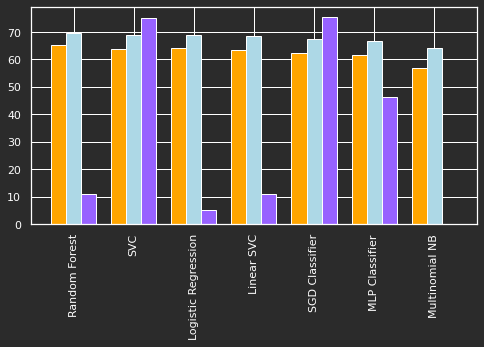

In [48]:
x = np.arange(len(fin_models))
width = 0.25

plt.figure(figsize=(8,4), facecolor='#2B2B2B')
plt.bar(x-width,fin_models['Precision'],color='orange',width=width)
plt.bar(x,fin_models['Accuracy'],color='lightblue',width=width)
#plt.bar(x+width,fin_models['TIME'],color='#9762FF',width=width)
plt.xticks(x,fin_models['Name'],color='white')
plt.yticks(color='white')
plt.xticks(rotation=90)
plt.gca().set_facecolor('#2B2B2B')

plt.show()

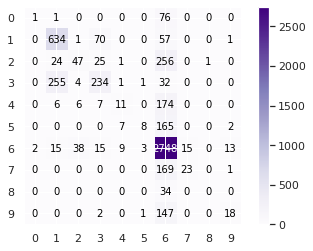

In [60]:
best = fin_models.iloc[0]

fig, ax = plt.subplots()
im = ax.imshow(best['ConfusionMatrix'], interpolation='nearest', cmap=plt.cm.Purples)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(best['ConfusionMatrix'].shape[1]),
       yticks=np.arange(best['ConfusionMatrix'].shape[0]))
        
# Añadir anotaciones en los bloques de la matriz
thresh = best['ConfusionMatrix'].max() / 2.0
for i in range(best['ConfusionMatrix'].shape[0]):
    for j in range(best['ConfusionMatrix'].shape[1]):
        ax.text(j, i, format(best['ConfusionMatrix'][i, j], 'd'),
                ha="center", va="center",
                color="white" if best['ConfusionMatrix'][i, j] > thresh else "black")


plt.show()



# SOLUCIÓN

In [26]:
## cada x_text encontrar en datos['Text'] y dar title+description y elemento de lista_clus_sol
#solucions = pd.read_pickle('D:/USUARIS/v4nf6qz/Desktop/v4nf6qz/p/fotos_tfg/def2/data2_clus_tfidf_sol.pickle')
for texto,clus in zip(X_test,pred[0]):
    ll = texto.split(' ')
    indexx = list(datos2['Text']).index(ll)
    break
print(indexx)
print(datos2.iloc[indexx]['Title'])
print(datos2.iloc[indexx]['Description'])
print(dic_clus_sol[clus])


2400
['ACME', 'Consulta']
['usuario', 'realiza', 'consulta', 'no', 'procede', 'No', 'gestionamos', 'ACME', 'debe', 'realizar', 'peticiónconsulta', 'mediante', 'herramienta', 'ONLINE', 'ACME']
['usuario', 'ACME', 'dispone', 'usted', 'manuales', 'detallados', 'disponibles', 'intranet', 'SEAT', 'Guías', 'Uso']


# HASTA AQUÍ EL TRABAJO. MÁS ABAJO TODAS LAS PRUEBAS REALIZADAS CON REDES NEURONALES QUE POSTERIORMENTE SE APLICARAN A LA INTEGRACIÓN. SE CONTINÚA CON EL ESTUDIO/TRABAJO

DATOSSS

In [15]:
listaa = []
for lista in list(datos2['Text']):
    sentence = ' '.join(lista)
    listaa.append(sentence)
    
listaa2 = []
for lista in list(datos2['Solution']):
    sentence = ' '.join(lista)
    listaa2.append(sentence)

X_train, X_test, y_train, y_test = train_test_split(listaa, listaa2, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

#vectorizer.fit(X_train)
train_text = vectorizer.fit_transform(X_train)
#vectorizer.fit(X_test)
test_text = vectorizer.transform(X_test)
#vectorizer.fit(X_val)
#test_val = vectorizer.transform(X_val)

#vectorizer.fit(y_train)
train_text_y = vectorizer.transform(y_train)
#vectorizer.fit(y_test)
test_text_y = vectorizer.transform(y_test)
#vectorizer.fit(X_val)
#test_val_y = vectorizer.transform(y_val)

x = train_text.toarray()
x2 = test_text.toarray()
#xx = test_val.toarray()

y = train_text_y.toarray()
y2 = test_text_y.toarray()
#yy = test_val.toarray()

#y = np.array(y_train)
#y2 = np.array(y_test)
#yy = np.array(y_val)


In [16]:
unique_elements = set()

for sublist in x:
    unique_elements.update(sublist)

l = list(unique_elements)


In [17]:
vocab_size = len(l)
vocab_size += 1
vocab_size

193695

In [18]:
longitud_maxima = max(len(sublista) for sublista in x)
longitud_maxima

20193

In [19]:
if x.shape[0] == y.shape[0]:
    print("x y y se corresponden")

else:
    print("x y y no se corresponden")
print(x.shape)
print(y.shape)

x y y se corresponden
(8756, 20193)
(8756, 20193)


# CNN

In [20]:
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
import torch
from tensorflow.keras import optimizers

"""
model = Sequential()
model.add(layers.Embedding(193695, 10, input_length=20193))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#model.summary()

history = model.fit(x, y,
                    epochs=10,
                    verbose=False,
                    validation_data=(xx, yy),
                    batch_size=10)


model = Sequential()
model.add(layers.Embedding(vocab_size, 10, input_length=longitud_maxima))  # Aumentamos el tamaño de embedding
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GRU(64, return_sequences=True))  # Agregamos una capa GRU
model.add(layers.GRU(64))  # Agregamos otra capa GRU
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) #mse
#model.summary()

model = Sequential()
model.add(layers.Embedding(vocab_size, 10, input_length=longitud_maxima))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GRU(64, return_sequences=True))
model.add(layers.GRU(64))
model.add(layers.Dense(longitud_maxima, activation='linear'))  # Cambiamos la activación a 'linear'
model.compile(optimizer='adam',
              loss='mean_squared_error')  # Cambiamos la pérdida a 'mean_squared_error'
history = model.fit(x, y,
                    epochs=5,
                    verbose=False,
                    validation_data=(xx, yy),
                    batch_size=10)
"""
model = Sequential()
model.add(layers.Embedding(vocab_size, 10, input_length=longitud_maxima))
model.add(layers.GRU(64))
model.add(layers.Dense(longitud_maxima, activation='linear'))

model.compile(optimizer='adam',
              loss='mean_squared_error')

model.fit(x, y, epochs=5, batch_size=256)

loss, accuracy = model.evaluate(x, y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x2, y2, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)


Epoch 1/5


ResourceExhaustedError:    OOM when allocating tensor with shape[256,192] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node while/BiasAdd
 (defined at D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\backend.py:6134)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[sequential_1/gru_1/PartitionedCall]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_6114]

Errors may have originated from an input operation.
Input Source operations connected to node while/BiasAdd:
In[0] while/MatMul (defined at D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\backend.py:2134)	
In[1] while/BiasAdd/unstack:

Operation defined at: (most recent call last)
>>>   File "C:\Users\v4nf6qz\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\v4nf6qz\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\traitlets\config\application.py", line 976, in launch_instance
>>>     app.start()
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
>>>     self.io_loop.start()
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\v4nf6qz\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 601, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\v4nf6qz\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1905, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\v4nf6qz\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
>>>     await result
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
>>>     res = shell.run_cell(
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\v4nf6qz\AppData\Local\Temp\1\ipykernel_11212\3114193259.py", line 58, in <cell line: 58>
>>>     model.fit(x, y, epochs=5, batch_size=256)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\engine\training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\engine\sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\engine\functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\layers\recurrent.py", line 679, in __call__
>>>     return super(RNN, self).__call__(inputs, **kwargs)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\layers\recurrent_v2.py", line 443, in call
>>>     last_output, outputs, runtime, states = self._defun_gru_call(
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\layers\recurrent_v2.py", line 521, in _defun_gru_call
>>>     last_output, outputs, new_h, runtime = gru_with_backend_selection(
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\layers\recurrent_v2.py", line 821, in gru_with_backend_selection
>>>     last_output, outputs, new_h, runtime = defun_standard_gru(**params)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\layers\recurrent_v2.py", line 598, in standard_gru
>>>     last_output, outputs, new_states = backend.rnn(
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\backend.py", line 4654, in rnn
>>>     final_outputs = tf.compat.v1.while_loop(
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\backend.py", line 4640, in _step
>>>     output, new_states = step_function(current_input,
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\layers\recurrent_v2.py", line 580, in step
>>>     matrix_x = backend.bias_add(matrix_x, input_bias)
>>> 
>>>   File "D:\USUARIS\v4nf6qz\Desktop\v4nf6qz\p\.venv\lib\site-packages\keras\backend.py", line 6134, in bias_add
>>>     return tf.nn.bias_add(x, bias, data_format='NHWC')
>>> 

Function call stack:
train_function -> train_function -> train_function -> while_body_4988_rewritten


72 minutacos

Training Accuracy: 0.5427
Testing Accuracy:  0.5331

In [ ]:
predictions = model.predict(padded_problem)

# Decodificación de la predicción
predicted_index = np.argmax(predictions[0])
predicted_solution = class_names[predicted_index]

# RNN

In [11]:
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
import torch
from tensorflow.keras import optimizers

model_rnn = Sequential()
model_rnn.add(layers.Embedding(vocab_size, 10, input_length=longitud_maxima))
model_rnn.add(layers.LSTM(128, return_sequences=True))
model_rnn.add(layers.Dropout(0.2))
model_rnn.add(layers.LSTM(64))
model_rnn.add(layers.Dropout(0.2))
model_rnn.add(layers.Dense(64, activation='relu'))
model_rnn.add(layers.Dense(10, activation='softmax'))

model_rnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history = model_rnn.fit(x, y,
                    epochs=5,
                    verbose=False,
                    validation_data=(xx, yy),
                    batch_size=32,
                    shuffle=False)

loss, accuracy = model_rnn.evaluate(x, y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_rnn.evaluate(x2, y2, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

In [15]:
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20193, 10)         1937520   
                                                                 
 lstm (LSTM)                 (None, 20193, 128)        71168     
                                                                 
 dropout (Dropout)           (None, 20193, 128)        0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 10)                6

In [ ]:
from tensorflow import keras

# Exportar el modelo a 'SavedModel'
keras.experimental.export_saved_model(model, 'path_to_saved_model')

# Recrea exactamente el mismo modelo
new_model = keras.experimental.load_from_saved_model('path_to_saved_model')

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(x,128,False)
val_loader = DataLoader(y,64,False)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.5, weight_decay=1e-5)

@torch.no_grad()  # prevent this function from computing gradients 
def validate(criterion, model, loader):

    val_loss = 0
    correct = 0

    model.eval()

    for data, target in loader:


        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()                                                              
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset), accuracy))


    return val_loss


def train(epoch, criterion, model, optimizer, loader):
    
    total_loss = 0.0

    model.train()

    for batch_idx, (data, target) in enumerate(loader):
        
        optimizer.zero_grad()

        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))


        total_loss += loss.item()  #.item() is very important here? Why?

    return total_loss / len(loader.dataset)

In [ ]:
losses = {"train": [], "val": []}
for epoch in range(10):

    train_loss = train(epoch, criterion, model_rnn, optimizer, train_loader)
    val_loss = validate(criterion, model_rnn, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    
    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()

In [ ]:
    predicciones = model.predict(test_text)


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#assert torch.cuda.is_available(), "GPU is not enabled"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class CNN(nn.Module): #kernel_size(5x5) -> f = 5, stride = 1, padding = 0 --> w'=w-f+1 i h'=h-f+1

    def __init__(self, n_feature, output_size): #creem les capes
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size = 5)
        #self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*12*12, 50)
        self.fc2 = nn.Linear(50, 10)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    #connectem les capes entre sí
    def forward(self, x): #b,1,28,28 ########################## IMPORTANT #################
        x = self.conv1(x) #(28+2*0-5)+1 = 24 --- #b,n_feature(out_channels),24,24
        x = F.relu(x) #no canvia    #b,n_feature,24,24
        x = self.maxpool(x) #b,n_feature,12,12 --> dividim entre 2 pq adalt hem dit kernel_size=2 i llavors es 2x2 
        #x = self.conv2(x) #(12+2*0-5)+1 = 8 --- #b,n_feature,8,8
        #x = F.relu(x) #no canvia    #b,n_feature,8,8
        #x = self.maxpool(x) #b,n_feature,4,4
        x = x.view(-1, self.n_feature*12*12) #b,n_feature*12*12
        #x = torch.flatten(x): no pq còpia a memòria, FLATTEN: la sortida del maxpool ho passa a vectors de una dimensio i es l'entrada d'una fully conected
        x = self.fc1(x) #b,50
        x = F.relu(x) #no canvia --> #b,50
        x = self.fc2(x) #b,10 (fiquem un 10 adalt definit pq en aquest dataset hi ha 10 classes de sortida)
        return x
    

torch.backends.cudnn.benchmark = True
learning_rate = 1e-2
lambda_l2 = 1e-5
momentum = 0.5
torch.manual_seed(0) # seed for reproductibility

output_size = 10  # there are 10 classes

model = CNN(6, output_size)  #n_features=6

#print(f"Number of parameters {get_n_params(model)}:")

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=lambda_l2) # built-in L2

# MLP

In [77]:
import torch.nn as nn # nn package to create our linear model
import torch


class SimpleMLP(nn.Module):
  def __init__(self, inp_dim, hidden_dim, output_dim):
    super().__init__()
    self.fc1 = nn.Linear(inp_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    out = self.fc1(x)
    return self.fc2(out)
  
modelMLP = SimpleMLP(10,10,10)

criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
learning_rate = 1e-3
lambda_l2 = 1e-5

# we use the optim package to apply gradient descent for our parameter updates
optimizer = torch.optim.SGD(modelMLP.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2




In [ ]:
# Training loop
def train(x_train, y_train, x_val, y_val, criterion, model, optimizer, epochs=300, visualize_surface=False):
    
    losses = {"train": [], "val": []} # Two lists to keep track of the evolution of our losses

    for t in range(epochs):
        
        # activate training mode
        model.train()
        
        # Feed forward to get the logits
        y_pred = model(x_train) # x_train is the whole batch, so we are doing batch gradient descent
    
        # Compute the loss
        loss = criterion(y_pred.squeeze(), y_train)
        
        # zero the gradients before running the backward pass
        optimizer.zero_grad()
        
        # Backward pass to compute the gradient of loss w.r.t our learnable params
        loss.backward()

        # Update params
        optimizer.step()

        # Compute the accuracy.
        score, predicted = torch.max(y_pred, 1) # torch.max() returns the maximum value and the argmax (index of the maximum value)
        train_acc = (y_train == predicted).sum().float() / len(y_train)
        losses["train"].append(loss.cpu().detach().numpy()) # keep track of our training loss

        # Run model on validation data
        val_loss, val_acc = calculateLossAcc(criterion, model, x_val, y_val) # Call our helper function on the validation set
        losses["val"].append(val_loss.cpu().detach().numpy()) # keep track of our validation loss

        # Create plots
        #display.clear_output(wait=True)
        #draw_plots(x_val, y_val, model, losses, visualize_surface, visualize_regressor = False)

        print("Training: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), train_acc))        
        print("Validation: [EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, val_loss.item(), val_acc))
        
    return losses # In case we want to plot them afterwards

# A helper function that calculates our loss and accuracy on a given dataset (by default on our validation set)
def calculateLossAcc(criterion, model, x, y):

    # set model in evaluation mode
    model.eval()
    with torch.no_grad(): # do not compute gradients for validation
        y_pred = model(x)


    # compute loss and accuracy 
    _, predicted = torch.max(y_pred, 1)
    loss = criterion(y_pred.squeeze(), y)
    acc = (y == predicted).sum().float() / len(y)

    return loss, acc

In [ ]:
losses = train(xBlobsTrain, yBlobsTrain, xBlobsVal, yBlobsVal, criterion, modelMLP, optimizer, visualize_surface=True, epochs = 100)

# BERT

In [ ]:
d = list(datos2['Text'])
d2 = list(datos2['cluster'])

##### EL BERT NECESITA WORD2VEC!! 

labels = list(set(d2))

# Dividir los datos en un 70% para el primer dataset y un 30% para el segundo dataset
X_train, X_test, y_train, y_test = train_test_split(d, d2, test_size=0.3, random_state=42)

# Crear el primer dataset (70% aleatorio)
df_train = pd.DataFrame({'Text': X_train, 'Label': y_train})
lista = df_train.values.tolist()

# Crear el segundo dataset (30% restante)
df_test = pd.DataFrame({'Text': X_test, 'Label': y_test})

In [87]:
from transformers import BertTokenizer, BertForSequenceClassification, GPT2Tokenizer, GPT2LMHeadModel
import torch

modelo_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=10)
modelo_beto = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels=num_etiquetas)

# Tokenizers para BERT
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

"""
# Clasificación con BERT
tokens_clasificacion = tokenizer_bert.encode_plus(
    lista,
    max_length=128,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_attention_mask=True,
    return_tensors='pt'
)
outputs_bert_clasificacion = modelo_bert(**tokens_clasificacion)
"""


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

"\n# Clasificación con BERT\ntokens_clasificacion = tokenizer_bert.encode_plus(\n    lista,\n    max_length=128,\n    truncation=True,\n    padding='max_length',\n    add_special_tokens=True,\n    return_attention_mask=True,\n    return_tensors='pt'\n)\noutputs_bert_clasificacion = modelo_bert(**tokens_clasificacion)\n"

In [88]:
# Procesamiento de los textos
for texto_etiqueta in lista: #lista_textos
    texto = texto_etiqueta[0]
    etiqueta = texto_etiqueta[1]
    tokens = tokenizer_bert.encode_plus(
        texto,
        max_length=128,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    outputs = modelo_bert(**tokens)
    # Aquí puedes realizar el procesamiento adicional de los resultados según tus necesidades

    """
    
     # Obtener las etiquetas predichas
    logits = outputs.logits
    predicted_labels = logits.argmax(dim=1)
    predicted_label = predicted_labels.item()

    print("Texto:", texto)
    print("Etiqueta verdadera:", etiqueta)
    print("Etiqueta predicha:", predicted_label)
    print()
    """


In [89]:
# Resultados de clasificación con BERT
probs_bert = outputs.logits.softmax(dim=1).squeeze()
pred_label_bert = torch.argmax(probs_bert).item()

"""
# Imprimir los resultados
print(f"Texto de clasificación: {texto}")
print(f"Predicción de BERT: {pred_label_bert}")
print(f"Probabilidades de BERT: {probs_bert.tolist()}")
"""

'\n# Imprimir los resultados\nprint(f"Texto de clasificación: {texto}")\nprint(f"Predicción de BERT: {pred_label_bert}")\nprint(f"Probabilidades de BERT: {probs_bert.tolist()}")\n'

In [91]:
print(pred_label_bert)
print(texto)
print(etiqueta)

8
['acme', 'notif', 'departament', 'respons', 'notific', 'departament', 'respons', 'ser', 'regulariz', 'asignadl', 'grup', 'ams', 'it', 'cross', 'servic', 'open', 'support', 'seat', 'much', 'adrian', 'fuster', 'carrill', 'jav', 'develop', 'dxc', 'technology', 'edifici', 'call', 'bari', '11', 'plaz', '50197', 'zaragoz', 'spain']
2


In [ ]:
"""
modelo_gpt = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer_gpt = GPT2Tokenizer.from_pretrained('gpt2')

# Generación de texto con GPT2
tokens_generacion = tokenizer_gpt.encode_plus(
    texto_generacion,
    max_length=128,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_attention_mask=True,
    return_tensors='pt'
)
outputs_gpt_generacion = modelo_gpt.generate(**tokens_generacion)

# Resultados de generación de texto con GPT2
texto_generado_gpt = tokenizer_gpt.decode(outputs_gpt_generacion[0], skip_special_tokens=True)
print()
print(f"Texto de generación: {texto_generacion}")
print(f"Texto generado por GPT2: {texto_generado_gpt}")
"""

In [95]:
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

modelo_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=10)
#modelo_beto = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels=num_etiquetas)

# Datos de entrenamiento y prueba
d = list(datos2['Text'])
d2 = list(datos2['cluster'])

# Dividir los datos en conjuntos de entrenamiento y prueba
#textos_train, textos_test, etiquetas_train, etiquetas_test = train_test_split(textos, etiquetas, test_size=0.2, random_state=42)
textos_train, textos_test, etiquetas_train, etiquetas_test = train_test_split(d, d2, test_size=0.3, random_state=42)


# Inicializar el tokenizer de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

# Preprocesar los datos de entrenamiento
inputs_train = []
for textos in textos_train:
    encoded_input = tokenizer.encode_plus(textos, padding='longest', truncation=True, max_length=128, return_tensors='pt')
    inputs_train.append(encoded_input)
labels_train = torch.tensor(etiquetas_train)

# Preprocesar los datos de prueba
inputs_test = []
for textos in textos_test:
    encoded_input = tokenizer.encode_plus(textos, padding='longest', truncation=True, max_length=128, return_tensors='pt')
    inputs_test.append(encoded_input)
labels_test = torch.tensor(etiquetas_test)

# Inicializar y entrenar el modelo BERT
modelo_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10)
modelo_bert.train()
optimizer = torch.optim.AdamW(modelo_bert.parameters(), lr=1e-5)

for epoch in range(3):
    optimizer.zero_grad()
    for encoded_input, labels in zip(inputs_train, labels_train):
        outputs = modelo_bert(**encoded_input, labels=labels.unsqueeze(0))
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluar el modelo en el conjunto de prueba
modelo_bert.eval()
with torch.no_grad():
    predicted_labels = []
    for encoded_input in inputs_test:
        outputs = modelo_bert(**encoded_input)
        logits = outputs.logits
        predicted_label = logits.argmax(dim=1)
        predicted_labels.append(predicted_label)
    predicted_labels = torch.cat(predicted_labels)

# Calcular la precisión del modelo en el conjunto de prueba
accuracy = (predicted_labels == labels_test).sum().item() / len(labels_test)
print("Precisión del modelo: {:.2f}%".format(accuracy * 100))


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [26]:
d = list(datos2['Text'])
d2 = list(datos2['cluster'])
labels = list(set(d2))

# Dividir los datos en un 70% para el primer dataset y un 30% para el segundo dataset
X_train, X_test, y_train, y_test = train_test_split(d, d2, test_size=0.3, random_state=42)

# Crear el primer dataset (70% aleatorio)
df_train = pd.DataFrame({'Text': X_train, 'Label': y_train})

# Crear el segundo dataset (30% restante)
df_test = pd.DataFrame({'Text': X_test, 'Label': y_test})

labels = df_train['Label'].unique()
# Crear las columnas con valores de 0 o 1 dependiendo del índice y el valor
for label in labels:
    nom = 'cluser_'+str(label)
    df_train[nom] = df_train['Label'].apply(lambda x: 1 if x == label else 0)
df_train = df_train.drop('Label',axis=1)
#print(df_train)

labels = df_test['Label'].unique()
# Crear las columnas con valores de 0 o 1 dependiendo del índice y el valor
for label in labels:
    nom = 'cluser_'+str(label)
    df_test[nom] = df_test['Label'].apply(lambda x: 1 if x == label else 0)
df_test = df_test.drop('Label',axis=1)
#print(df_test)

df_train.to_csv('D:/USUARIS/v4nf6qz/Desktop/v4nf6qz/p/fotos_tfg/def/train.csv')
df_test.to_csv('D:/USUARIS/v4nf6qz/Desktop/v4nf6qz/p/fotos_tfg/def/val.csv')
np.savetxt('D:/USUARIS/v4nf6qz/Desktop/v4nf6qz/p/fotos_tfg/def/labels.csv', labels, delimiter=',') #HACERLO A MANO
#labels.to_csv('fotos_tfg/def/labels.csv')

col = df_train.columns
col = col[1:]
print(col)


Index(['cluser_0', 'cluser_2', 'cluser_5', 'cluser_8', 'cluser_6', 'cluser_4',
       'cluser_3', 'cluser_7', 'cluser_1', 'cluser_9'],
      dtype='object')


In [19]:
from fast_bert.data_cls import BertDataBunch
from apex.amp import amp

databunch = BertDataBunch('D:/USUARIS/v4nf6qz/Desktop/v4nf6qz/p/fotos_tfg/def/', 'D:/USUARIS/v4nf6qz/Desktop/v4nf6qz/p/fotos_tfg/def/',
                          tokenizer='bert-base-uncased',
                          train_file='train.csv',
                          val_file='val.csv',
                          label_file='D:/USUARIS/v4nf6qz/Desktop/v4nf6qz/p/fotos_tfg/def/labels.csv',
                          text_col='Text',
                          label_col=col,
                          batch_size_per_gpu=16,
                          max_seq_length=512,
                          multi_gpu=True,
                          multi_label=False,
                          model_type='bert')

ValueError: Connection error, and we cannot find the requested files in the cached path. Please try again or make sure your Internet connection is on.

In [ ]:
@torch.no_grad()  # prevent this function from computing gradients 
def validate(criterion, model, loader):

    val_loss = 0
    correct = 0

    model.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()                                                              
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset), accuracy))


    return val_loss


def train(epoch, criterion, model, optimizer, loader):
    
    total_loss = 0.0

    model.train()

    for batch_idx, (data, target) in enumerate(loader):
        
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)
        
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))


        total_loss += loss.item()  #.item() is very important here? Why?

    return total_loss / len(loader.dataset)